In [1]:
!pip install pyspark

In [2]:
from pyspark.sql import SparkSession
spark=SparkSession.builder\
    .appName("BigDataAnalyticsProject")\
    .config("spark.sql.shuffle.partitions","8")\
    .getOrCreate()
spark


In [3]:
import pandas as pd
import numpy as np

np.random.seed(42)
rows=100000
data={
    "OrderID":np.arange(1,rows+1),
    "CustomerID":np.random.randint(1000,2000,rows),
    "Country":np.random.choice(["India", "USA", "UK", "Germany", "Canada"],rows),
    "Product":np.random.choice(["Laptop", "Phone", "Tablet", "Headphones"],rows),
    "Amount":np.random.randint(100,5000,rows),
    "Quantity":np.random.randint(1,5,rows)
}
pdf=pd.DataFrame(data)
pdf.to_csv("sales_data.csv",index="False")

In [4]:
df=spark.read.csv("sales_data.csv",header="True",inferSchema="True")
df.show(5)
df.printSchema()

+---+-------+----------+-------+----------+------+--------+
|_c0|OrderID|CustomerID|Country|   Product|Amount|Quantity|
+---+-------+----------+-------+----------+------+--------+
|  0|      1|      1102|    USA|     Phone|  4492|       3|
|  1|      2|      1435|Germany|    Tablet|  2969|       2|
|  2|      3|      1860|  India|     Phone|  4748|       1|
|  3|      4|      1270|     UK|Headphones|  4017|       3|
|  4|      5|      1106|  India|Headphones|  4431|       2|
+---+-------+----------+-------+----------+------+--------+
only showing top 5 rows
root
 |-- _c0: integer (nullable = true)
 |-- OrderID: integer (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)
 |-- Product: string (nullable = true)
 |-- Amount: integer (nullable = true)
 |-- Quantity: integer (nullable = true)



In [5]:
df_clean=df.dropna().dropDuplicates()
df_clean.count()

100000

In [6]:
from pyspark.sql.functions import col
df_transformed=df_clean.withColumn(
    "TotalPrice",col("Amount")*col("Quantity")
    )

df_transformed.show(5)

+---+-------+----------+-------+----------+------+--------+----------+
|_c0|OrderID|CustomerID|Country|   Product|Amount|Quantity|TotalPrice|
+---+-------+----------+-------+----------+------+--------+----------+
|  1|      2|      1435|Germany|    Tablet|  2969|       2|      5938|
|  4|      5|      1106|  India|Headphones|  4431|       2|      8862|
|  8|      9|      1614|Germany|    Laptop|  3167|       3|      9501|
|  9|     10|      1121| Canada|    Laptop|  1223|       1|      1223|
| 13|     14|      1458|Germany|     Phone|  3875|       1|      3875|
+---+-------+----------+-------+----------+------+--------+----------+
only showing top 5 rows


In [7]:
df_transformed.createOrReplaceTempView("sales")

In [8]:
country_sales=spark.sql("""
    SELECT Country, SUM(TotalPrice) AS TotalRevenue
    FROM sales
    GROUP BY Country
    ORDER BY TotalRevenue DESC
""")
country_sales.show()

+-------+------------+
|Country|TotalRevenue|
+-------+------------+
|    USA|   127926891|
| Canada|   127710148|
|Germany|   127201907|
|  India|   126898736|
|     UK|   126289464|
+-------+------------+



In [9]:
top_customers=spark.sql("""
    SELECT CustomerID,SUM(TotalPrice) AS Revenue
    FROM sales
    GROUP BY CustomerID
    ORDER BY Revenue DESC
    LIMIT 10
""")
top_customers.show()

+----------+-------+
|CustomerID|Revenue|
+----------+-------+
|      1051| 892350|
|      1437| 883761|
|      1375| 878515|
|      1148| 869066|
|      1944| 861359|
|      1617| 859724|
|      1848| 857299|
|      1132| 848260|
|      1529| 846505|
|      1870| 841022|
+----------+-------+



In [10]:
product_sales=spark.sql("""
    SELECT Product,SUM(Quantity) AS TotalUnitsSOLD
    FROM sales
    GROUP BY product
    ORDER BY TotalUnitsSOLD
""")
product_sales.show()

+----------+--------------+
|   Product|TotalUnitsSOLD|
+----------+--------------+
|Headphones|         62170|
|    Tablet|         62269|
|    Laptop|         62296|
|     Phone|         63302|
+----------+--------------+



In [11]:
import time
start=time.time()
spark.sql("SELECT COUNT(*)FROM sales").show()
end=time.time()
print("Execution Time: ",end-start)

+--------+
|count(1)|
+--------+
|  100000|
+--------+

Execution Time:  1.199850082397461


In [12]:
df_transformed.cache()
df_transformed.count()

100000

In [13]:
start=time.time()
spark.sql("SELECT COUNT(*) FROM sales")
end=time.time()
print("Execution Time After Cache: ",end-start)

Execution Time After Cache:  0.042754411697387695


In [14]:
country_sales.explain(True)

== Parsed Logical Plan ==
'Sort ['TotalRevenue DESC NULLS LAST], true
+- 'Aggregate ['Country], ['Country, 'SUM('TotalPrice) AS TotalRevenue#105]
   +- 'UnresolvedRelation [sales], [], false

== Analyzed Logical Plan ==
Country: string, TotalRevenue: bigint
Sort [TotalRevenue#105L DESC NULLS LAST], true
+- Aggregate [Country#20], [Country#20, sum(TotalPrice#72) AS TotalRevenue#105L]
   +- SubqueryAlias sales
      +- View (`sales`, [_c0#17, OrderID#18, CustomerID#19, Country#20, Product#21, Amount#22, Quantity#23, TotalPrice#72])
         +- Project [_c0#17, OrderID#18, CustomerID#19, Country#20, Product#21, Amount#22, Quantity#23, (Amount#22 * Quantity#23) AS TotalPrice#72]
            +- Deduplicate [Quantity#23, _c0#17, Product#21, Country#20, CustomerID#19, OrderID#18, Amount#22]
               +- Filter atleastnnonnulls(7, _c0#17, OrderID#18, CustomerID#19, Country#20, Product#21, Amount#22, Quantity#23)
                  +- Relation [_c0#17,OrderID#18,CustomerID#19,Country#20,Pro

In [15]:
country_sales.write.mode("overwrite").parquet("output_parquet")

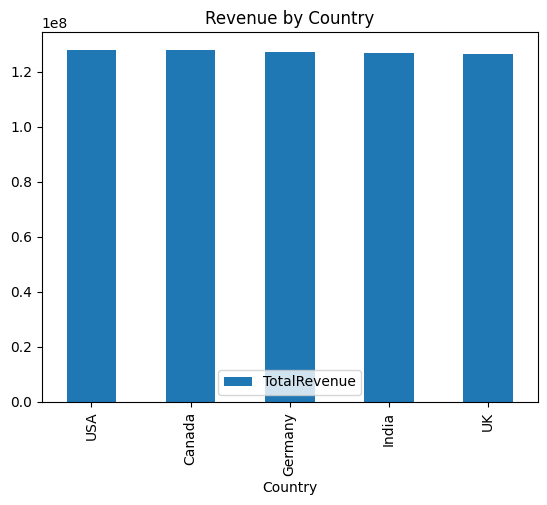

In [16]:
import matplotlib.pyplot as plt
pdf_country=country_sales.toPandas()
pdf_country.plot(kind="bar",x="Country",y="TotalRevenue")
plt.title("Revenue by Country")
plt.show()

In [17]:
import pandas as pd
import numpy as np

np.random.seed(42)

rows = 1_000_000  # 1 Million

data = {
    "OrderID": np.arange(1, rows + 1),
    "CustomerID": np.random.randint(1000, 5000, rows),
    "Country": np.random.choice(["India", "USA", "UK", "Germany", "Canada"], rows),
    "Product": np.random.choice(["Laptop", "Phone", "Tablet", "Headphones"], rows),
    "Amount": np.random.randint(100, 5000, rows),
    "Quantity": np.random.randint(1, 5, rows)
}

pdf = pd.DataFrame(data)
pdf.to_csv("sales_data_large.csv", index=False)


In [18]:
from pyspark.sql.types import StructType,StructField,IntegerType,StringType
schema=StructType([
    StructField("OrderID", IntegerType(), True),
    StructField("CustomerID", IntegerType(), True),
    StructField("Country", StringType(), True),
    StructField("Product", StringType(), True),
    StructField("Amount", IntegerType(), True),
    StructField("Quantity", IntegerType(), True)
])
df=spark.read.csv("sales_data_large.csv",header=True,schema=schema)


In [19]:
from pyspark.sql.functions import col
df=df.withColumn("TotalPrice",col("Amount")*col("Quantity"))

In [20]:
from pyspark.sql.window import Window
from pyspark.sql.functions import sum as spark_sum, rank, col

customer_revenue = df.groupBy("Country", "CustomerID") \
    .agg(spark_sum("TotalPrice").alias("Revenue"))

window_spec = Window.partitionBy("Country").orderBy(col("Revenue").desc())

ranked_customers = customer_revenue.withColumn(
    "Rank",
    rank().over(window_spec)
)

ranked_customers.show(10)


+-------+----------+-------+----+
|Country|CustomerID|Revenue|Rank|
+-------+----------+-------+----+
| Canada|      2203| 562620|   1|
| Canada|      2194| 515049|   2|
| Canada|      2445| 512892|   3|
| Canada|      2888| 511267|   4|
| Canada|      1421| 510345|   5|
| Canada|      4206| 503733|   6|
| Canada|      3061| 500543|   7|
| Canada|      1082| 499479|   8|
| Canada|      4856| 498165|   9|
| Canada|      1902| 498066|  10|
+-------+----------+-------+----+
only showing top 10 rows


In [21]:
product_category = spark.createDataFrame([
    ("Laptop", "Electronics"),
    ("Phone", "Electronics"),
    ("Tablet", "Electronics"),
    ("Headphones", "Accessories")
], ["Product", "Category"])


In [22]:
from pyspark.sql.functions import broadcast

joined_df = df.join(
    broadcast(product_category),
    "Product",
    "inner"
)

joined_df.show(5)


+----------+-------+----------+-------+------+--------+----------+-----------+
|   Product|OrderID|CustomerID|Country|Amount|Quantity|TotalPrice|   Category|
+----------+-------+----------+-------+------+--------+----------+-----------+
|     Phone|      1|      4174|Germany|  2780|       2|      5560|Electronics|
|Headphones|      2|      4507| Canada|  3287|       4|     13148|Accessories|
|     Phone|      3|      1860|    USA|  2217|       1|      2217|Electronics|
|    Tablet|      4|      2294|  India|   755|       1|       755|Electronics|
|Headphones|      5|      2130|Germany|  4897|       2|      9794|Accessories|
+----------+-------+----------+-------+------+--------+----------+-----------+
only showing top 5 rows


In [23]:
df.write \
  .mode("overwrite") \
  .partitionBy("Country") \
  .parquet("data_lake/sales_partitioned")


In [24]:
ranked_customers.explain(True)


== Parsed Logical Plan ==
'Project [unresolvedstarwithcolumns(Rank, 'rank() windowspecdefinition('Country, 'Revenue DESC NULLS LAST, unspecifiedframe$()), None)]
+- Aggregate [Country#858, CustomerID#857], [Country#858, CustomerID#857, sum(TotalPrice#863) AS Revenue#864L]
   +- Project [OrderID#856, CustomerID#857, Country#858, Product#859, Amount#860, Quantity#861, (Amount#860 * Quantity#861) AS TotalPrice#863]
      +- Relation [OrderID#856,CustomerID#857,Country#858,Product#859,Amount#860,Quantity#861] csv

== Analyzed Logical Plan ==
Country: string, CustomerID: int, Revenue: bigint, Rank: int
Project [Country#858, CustomerID#857, Revenue#864L, Rank#873]
+- Project [Country#858, CustomerID#857, Revenue#864L, Rank#873, Rank#873]
   +- Window [rank(Revenue#864L) windowspecdefinition(Country#858, Revenue#864L DESC NULLS LAST, specifiedwindowframe(RowFrame, unboundedpreceding$(), currentrow$())) AS Rank#873], [Country#858], [Revenue#864L DESC NULLS LAST]
      +- Project [Country#858, 

In [25]:
import os
os.makedirs("stream_input",exist_ok=True)

In [26]:
stream_df=spark.readStream\
    .schema(schema)\
    .csv("stream_input")

In [27]:
from pyspark.sql.functions import col
stream_df=stream_df.withColumn("TotalPrice",col("Amount")*col("Quantity"))

In [29]:
revenue_stream=stream_df.groupBy("Country")\
    .sum("TotalPrice")

In [ ]:
query=revenue_stream.writeStream\
    .outputMode("complete")\
    .format("console")\
    .start()
query.awaitTermination()

In [ ]:
import time

start = time.perf_counter()
spark.sql("SELECT COUNT(*) FROM sales").show()
end = time.perf_counter()

print("Without Cache:", end - start)


In [ ]:
df.cache()
df.count()

start = time.perf_counter()
spark.sql("SELECT COUNT(*) FROM sales").show()
end = time.perf_counter()

print("With Cache:", end - start)


In [ ]:
print("Partitions:", df.rdd.getNumPartitions())


In [ ]:
df_repartitioned = df.repartition(16)


In [ ]:
df.explain(True)
